# Coding a Neural Net from Scratch: Word2Vec

## Code Preamble

In [1]:
import numpy as np
import re

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

## Resources

Work forked from Jake Tae with modifications, additions and clarifications: 

- [Jake Tae](https://jaketae.github.io): [Word2vec from Scratch ](https://jaketae.github.io/study/word2vec)

Other resources: 
- [Eric Kim](https://aegis4048.github.io): [Demystifying Neural Network in Skip-Gram Language Modeling](https://aegis4048.github.io/demystifying_neural_network_in_skip_gram_language_modeling)

## Introduction

- Today we'll implement the Word2Vec model from scratch in Numpy
- Word2vec was introduced in a 2013 paper and sent shock waves through the NLP world, along with the similar GloVe model
- Given a word, Word2Vec predicts it context (or vice versa). 
- However, this isn't the main point of the model:
- Goal: Produce a good representation of language through the LM task

## Architectures

- Word2vec has two separate architectures:
    - **Skipgram (SG)**: Predict context from target
    - **Disitributed Bag-of-Words (DBOW)**: Predict target from context
- There has since then been new iterations of W2V
    - **Paraghaph2Vec / Doc2Vec:** Vectors for entire documents
    - **FastText:** Skipgram but using ngram level tokenization 

## Today We Will Learn
    
- We will first implement the standard version of Skipgram with a toy example
- Then we'll expand the model to work with a larger dataset

## Why?

- Word2Vec encapsulates the basic logic of the language modelling paradigm
- Easy to implement and understand, unlike larger and more complex models like BERT or GPT
- Implementing it in Numpy we'll build intuition, later we'll use Torch for all our neural nets
    - You'll get an intro to Torch in the classification task

## Premise

**The Task:** *Can we write a neural network that predicts a word, given its context?*

<center>
<div>
<img src="../../img/skip-gram-paper.png" width="30%"
     caption="test"/>
    <figcaption>Original Skip-gram model architecture.</figcaption>
</div>
    </center>

**The Goal:** Produce vector representations that capture semantic (and other) relationships between words.

> The man who passes the sentence should swing the sword. - Ned Stark

<center>
<div>
<img src="../../img/word2vec3d.png" width="100%"
     caption="test"/>
    <figcaption>Original Producing data for the skipgram model.</figcaption>
</div>
</center>

# Intuition: Steps with 1 Training Example

## Data

In [4]:
text = '''The man who passes the sentence should swing the sword.'''

As so often, let's start by defining a tokenizer and tokenizing our data.

In [5]:
def tokenize(text):
    pattern = re.compile(r'[A-Za-z]+[\w^\']*|[\w^\']*[A-Za-z]+[\w^\']*')
    return pattern.findall(text.lower())

In [6]:
tokens = tokenize(text)

In [7]:
len(tokens)

10

In [8]:
print(tokens)

['the', 'man', 'who', 'passes', 'the', 'sentence', 'should', 'swing', 'the', 'sword']


In [9]:
len(list(set(tokens)))

8

Now, much like encoding things in bits, we can't just give a model the tokens as such. 
- Tokens need to be somehow intelligible for mathematical analysis.
- A common way of doing this, is to just give each unique token a number. 
    - This creates a two-way map, where each token has a number and each number has a token.

**PROMPT:** Write a function that returns two dictionaries:
    
1. ```word2idx```: Maps each unique token to a numerical index
2. ```idx2word```: Maps each idx to its corresponding token

**Hint:** Use ```enumerate```

In [10]:
def mapping(tokens):
    word2idx = {}
    idx2word = {}
    
    for i, token in enumerate(set(tokens)):
        word2idx[token] = i
        idx2word[i] = token
    
    return word2idx, idx2word

In [11]:
word2idx, idx2word = mapping(tokens)

In [12]:
list(word2idx.items())

[('who', 0),
 ('man', 1),
 ('sentence', 2),
 ('swing', 3),
 ('should', 4),
 ('the', 5),
 ('passes', 6),
 ('sword', 7)]

In [13]:
word2idx['sword']

7

In [14]:
list(idx2word.items())[:10]

[(0, 'who'),
 (1, 'man'),
 (2, 'sentence'),
 (3, 'swing'),
 (4, 'should'),
 (5, 'the'),
 (6, 'passes'),
 (7, 'sword')]

In [15]:
idx2word[0]

'who'

In a sense, we have created a lookup table that allows us to easily convert from words to indices, and indices to words. This will come in handy later!

### Training Data

- Now we want to create the input data for our neural network
- What w2v needs, is a sliding window with a target word and context words.

<center>
<div>
<img src="../../img/quote_ned_stark.png" width="100%"
     caption="test"/>
    <figcaption>Original Producing data for the skipgram model.</figcaption>
</div>
    </center>

It's rare that we have to generate this data and that's not the main exercise today, so we'll use a helper function for that.
- We will generate ```X``` and ```Y```
    - **X:** Our target words
    - **Y:** The corresponding context words

In [16]:
def one_hot_encode(id, vocab_size):
    res = [0] * vocab_size
    res[id] = 1
    return res

def concat(*iterables):
    for iterable in iterables:
        yield from iterable

def generate_training_data(tokens, word_to_id, window):
    X = []
    y = []
    n_tokens = len(tokens)
    for i in range(n_tokens):
        idx = concat(
            range(max(0, i - window), i), 
            range(i, min(n_tokens, i + window + 1))
        )
        for j in idx:
            if i == j:
                continue
            X.append(one_hot_encode(word_to_id[tokens[i]], len(word_to_id)))
            y.append(one_hot_encode(word_to_id[tokens[j]], len(word_to_id)))
    
    return np.asarray(X), np.asarray(y)

In [17]:
X, Y = generate_training_data(tokens, word2idx, 2)


Okay, let's take a look. 

In [18]:
X[:5]

array([[0, 0, 0, 0, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]])

In [19]:
X.shape

(34, 8)

**PROMPT:** What is going on in ```X```?

Each column in ```X``` represents a word. Because we have 8 unique tokens in our vocabulary, we have 8 columns. After generating the pairs for training, we have 34 pairs. Because our context window has two words in it, each row in ```X``` is repeated twice.

And the same goes for ```Y```. **Except**, ```Y``` mostly consists of separate words on every row.

In [20]:
Y.shape

(34, 8)

In [21]:
Y[:10]

array([[0, 1, 0, 0, 0, 0, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [1, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 1, 0, 0],
       [0, 1, 0, 0, 0, 0, 0, 0]])

### Weight matrices

In addition to our training data, we need to initialize the weight matrices. 
- Our network has one hidden layer, so we need two weights matrices. 
- The are initialized with ```np.random.randn``` because we want the initial values to be random.

In [22]:
def init_network(vocab_size, n_embedding):
    model = {
        "W_input": np.random.randn(vocab_size, n_embedding),
        "W_output": np.random.randn(n_embedding, vocab_size)
    }
    return model


In [23]:
model = init_network(len(word2idx), 3)

Each row in the matrix represents a word. The three columns represent the values in the embeddings.

In [24]:
model['W_input']

array([[-0.53693605, -0.38660829, -0.30777546],
       [ 0.07449955,  2.73973849, -0.5657546 ],
       [ 1.14203017,  1.34496399,  1.70454128],
       [ 0.04649057, -0.44623218,  0.99707546],
       [-0.76279773,  0.08389135,  1.33367059],
       [-1.42452529,  0.29526236,  0.16703612],
       [ 0.53484471,  0.07039194, -0.94075038],
       [ 1.18376426, -1.09623004,  0.64821686]])

<center>
<div>
<img src="../../img/embedding_matrix_input.png" width="30%"
     caption="test"/>
    <figcaption>Original Producing data for the skipgram model.</figcaption>
</div>
</center>

## Overview

Let's first take a look at the big picture. We'll walk over this step-by-step.

<center>
<div>
<img src="../../img/word2vec.png" width="100%"
     caption="test"/>
    <figcaption>Matrix operations for the Skipgram model.</figcaption>
</div>
    </center>

## Forward pass

### The Hidden Layer

- We begin by creating the hidden layer.
- We use $x$ to select the correct embedding from $W_{input}$. 
    - The hidden lauer $h$ is just this embedding!

<center>
<div>
<img src="../../img/x_w_input_h.png" width="80%"
     caption="test"/>
    <figcaption>Producing the hidden layer.</figcaption>
</div>
</center>

The matrices need to have appropriate shapes:

In [25]:
print(X[0].shape)
print(model['W_input'].shape)

(8,)
(8, 3)


**PROMPT:** How would you create the hidden layer using Python?

In [26]:
h = X[0] @ model["W_input"]
print(h.shape)
h

(3,)


array([-1.42452529,  0.29526236,  0.16703612])

Now the hidden layer is in turn multiplied by the matrix of the context vectors. 

First we check that the shapes match:

In [27]:
model["W_output"].shape

(3, 8)

They do. **However:** In the figure above we needed to tranpose ```W_output```. But, because Numpy gives ```h``` as a row vector, we don't have to do that here.

In [28]:
h

array([-1.42452529,  0.29526236,  0.16703612])

So we can proceed to multiply our hidden layer with the next set of weights. These are the embeddings for the context words!

In [29]:
O = h @ model["W_output"]
O.shape

(8,)

Now we have our output, which isn't showed in the figure.

In [30]:
O

array([ 2.69294918, -4.83461982,  0.08141413,  2.20424143, -2.29490799,
       -0.64172992,  1.01764994, -0.13082356])

**PROMPT:** What do these values indicate?

- The output is as long as the vocabulary, so it's length is 8 in our case.
- The higher the number, the more probable that the corresponding word 
- However, to get actual probabilities, we need one more step

And that's it! All that remains for us to have predictions, is to squeeze each row into a probability distribution.

### Activation: Softmax 

<center>
<div>
<img src="../../img/softmax_function.png" width="80%"
     caption="test"/>
    <figcaption>We take the softmax of the output layer.</figcaption>
</div>
</center>


To squeeze the values in the output vector into a probability distribution, we pass it through the softmax. I've created a function for that.

In [31]:
def softmax_one(x):
    exp = np.exp(x)
    return exp / exp.sum()

And now, *finally*, we can get our actual predictions!

In [32]:
y_pred = softmax_one(O)
y_pred

array([5.05955534e-01, 2.72226670e-04, 3.71481413e-02, 3.10362520e-01,
       3.45075006e-03, 1.80251802e-02, 9.47412553e-02, 3.00443928e-02])

There are 8 words in the vocabulary, so we have a prediction for each of them.

In [33]:
y_pred.shape

(8,)

The predictions sum to 1, so it's a proper probability distribution:

In [34]:
np.sum(y_pred)

1.0

And the max and min values in the array are bound by 0 and 1, as they should be if they express probabilities:

In [35]:
max(y_pred)

0.5059555339345886

In [36]:
min(y_pred)

0.00027222667002632395

Now we can wrap everything up and write a function for the forward pass of our neural network:

In [37]:
def forward(model, x, return_fwd=True):
    fwd_pass = {}
    fwd_pass["h"] = x @ model["W_input"]
    fwd_pass["O"] = fwd_pass["h"] @ model["W_output"]
    fwd_pass["y_pred"] = softmax_one(fwd_pass["O"])
    if not return_fwd:
        return fwd_pass["y_pred"]
    return fwd_pass

## Backpropagation

To pass corrections backward to the different layers of the model, we are going to use two familiar tools:

1. Cross-Entropy loss
2. The Chain Rule of Calculus

We can start by defining cross entropy. For this model, the two distributions that we are comparing are:
    
1. Our correct labels ```y```
2. And our predicted values ```y_pred```

So we can write our cross entropy function like this:

In [38]:
def cross_entropy(y_pred, y):
    return - np.sum(np.log(y_pred) * y)


If we apply the chain rule and if $L_{CE}$ stands for cross-entropy loss, then

$$
\frac{\partial L_{CE}}{\partial W_{i}} =
\frac{\partial L_{CE}}{\partial Y_{pred}} \cdot
\frac{\partial Y_{pred}}{\partial O} \cdot
\frac{\partial O}{\partial W_{o}} \cdot
\frac{\partial W_{o}}{\partial H} \cdot
\frac{\partial H}{\partial W_{i}}
$$

Effectively what we do with the cross entropy, is that we "wrap" the entire neural net

$$
H = X \cdot W_{input} \\
O = H \cdot W_{output} \\
Y_{pred} = \sigma (O)
$$

But we could also write this as:

$$
Y_{pred} = \sigma (W_{output}(X \cdot W_{input} ))
$$

So when we take the derivative of cross entropy, we should replace $z$ with this function. Seems tricky! And indeed, it's a pretty long and cumbersom mathematical derivation which we won't get into. But the outcome is actually very beautiful:

$$
\frac{\partial O}{\partial W_o} = Y_{pred} - Y
$$

So to calculate our corrections to each matrix that produces $y_pred$, we start by subtracting ```y``` from ```y_pred```. This gives us the gradient for the output:

In [39]:
dO = y_pred - Y[0]

In [40]:
dO

array([ 0.50595553, -0.99972777,  0.03714814,  0.31036252,  0.00345075,
        0.01802518,  0.09474126,  0.03004439])

For the other derivatives, we get:

$$
\frac{\partial H}{\partial W_{i}} = H^T \times \frac{\partial O}{\partial W_o}
$$

$$
\frac{\partial W_{i}}{\partial X} = X^T \times \frac{\partial H}{\partial W_i}
$$

However, what we're really trying to find are the gradients for our embedding matrices, i.e. ```dw_target``` and ```dw_context```. To find them, we have to apply the chain rule.

In [41]:
dw_output = h[np.newaxis].T @ dO[np.newaxis]

In [42]:
dh = dO @ model["W_output"].T

In [43]:
dw_input = X[0][np.newaxis].T @ dh[np.newaxis]

Finally, we set the learning rate, multiply it with our respective gradients and subtract the product from our embedding matrices.

In [44]:
lr = 0.01

In [45]:
model["W_input"] -= lr * dw_input
model["W_output"] -= lr * dw_output

Now we can wrap all of this in a function:

In [46]:
def backward(model, x, y, alpha):
    fwd_pass  = forward(model, x)
    dO = fwd_pass["y_pred"] - y
    dw_output = fwd_pass["h"][np.newaxis].T @ dO[np.newaxis]
    dh = dO @ model["W_output"].T
    dw_input = x[np.newaxis].T @ dh[np.newaxis]
    assert(dw_output.shape == model["W_output"].shape)
    assert(dw_input.shape == model["W_input"].shape)
    model["W_input"] -= alpha * dw_input
    model["W_output"] -= alpha * dw_output
    return cross_entropy(fwd_pass["y_pred"], y)


## Training the Model

In [47]:
model = init_network(len(word2idx), 3)

In [48]:
n_epochs = 500
learning_rate = 0.05
history = []

for epoch in range(0, n_epochs):
    for idx, _ in enumerate(X):
        history.append(backward(model, X[idx], Y[idx], learning_rate))

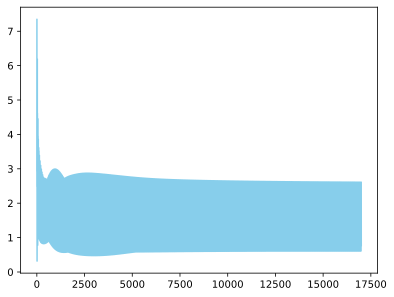

In [49]:
plt.plot(range(len(history)), history, color="skyblue")
plt.show()

## Beyond One Example

Normally we really don't want to train a neural net one example at a time. We did that for purely pedagogical reasons. 

If we want to instead run the network for a longer text and train all examples at once, we could take a longer example.

In [50]:
text = '''Machine learning is the study of computer algorithms that \
improve automatically through experience. It is seen as a \
subset of artificial intelligence. Machine learning algorithms \
build a mathematical model based on sample data, known as \
training data, in order to make predictions or decisions without \
being explicitly programmed to do so. Machine learning algorithms \
are used in a wide variety of applications, such as email filtering \
and computer vision, where it is difficult or infeasible to develop \
conventional algorithms to perform the needed tasks.'''

In [51]:
tokens_ = tokenize(text)
word2idx_, idx2word_ = mapping(tokens_)
X_, Y_ = generate_training_data(tokens_, word2idx_, 2)
model_ = init_network(len(word2idx_), 100)


We redefine softmax so it accepts an entire matrix.

In [52]:
def softmax_batch(X):
    res = []
    for x in X:
        exp = np.exp(x)
        res.append(exp / exp.sum())
    return res

And same for the forward function.

In [53]:
def forward(model, X, return_fwd=True):
    fwd_pass = {}
    fwd_pass["h"] = X @ model["W_input"]
    fwd_pass["O"] = fwd_pass["h"] @ model["W_output"]
    fwd_pass["y_pred"] = softmax_batch(fwd_pass["O"])
    
    if not return_fwd:
        return fwd_pass["y_pred"]
    return fwd_pass


And the backward function.

In [54]:
def backward(model, X, y, alpha):
    fwd_pass  = forward(model, X)
    dO = fwd_pass["y_pred"] - y
    dw2 = fwd_pass["h"].T @ dO
    dh = dO @ model["W_output"].T
    dw1 = X.T @ dh
    assert(dw2.shape == model["W_output"].shape)
    assert(dw1.shape == model["W_input"].shape)
    model["W_input"] -= alpha * dw1
    model["W_output"] -= alpha * dw2
    return cross_entropy(fwd_pass["y_pred"], y)

Now we can initialize the model again with this data. Let's make the vectors longer.

In [55]:
model_ = init_network(len(word2idx_), 10)

Let's train an plot the loss over time.

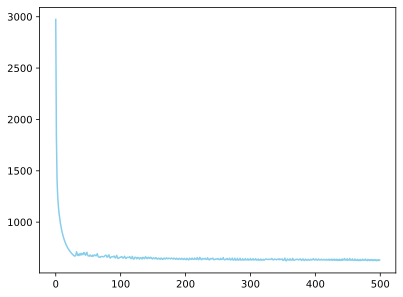

In [56]:
n_epochs_ = 500
learning_rate_ = 0.05

history = [backward(model_, X_, Y_, learning_rate_) for _ in range(n_epochs_)]

plt.plot(range(len(history)), history, color="skyblue")
plt.show()

In [57]:
learning = one_hot_encode(word2idx_["learning"], len(word2idx_))
result = forward(model_, [learning], return_fwd=False)[0]

for word in (idx2word_[id] for id in np.argsort(result)[::-1][:10]):
    print(word)


algorithms
machine
intelligence
so
are
build
the
is
do
subset


In [58]:
def get_embedding(model, word, word2idx):
    try:
        idx = word2idx[word]
    except KeyError:
        print("`word` not in corpus")
    one_hot = one_hot_encode(idx, len(word2idx))
    return forward(model, one_hot)["h"]


In [59]:
get_embedding(model_, "machine", word2idx_)


array([ 0.96491336, -1.47606237, -0.08471079, -0.72185855, -0.57790337,
        0.89352203,  0.51657305,  0.0655011 , -1.02635913, -0.681088  ])

## Creating a model class

So far we have kept the code fragmented in order to understand the different pieces. But this is not how you usually write an ML model. Instead, it's customary to wrap the model in an appropriate class with most relevant functions as methods. Let's do that now for our model.

In [60]:
class Word2VecSG():
    def __init__(self, X, Y, vocab_size, n_embedding, batch_size):
        self.X = X
        self.Y = Y
        self.w_target = np.random.randn(vocab_size, n_embedding)
        self.w_context = np.random.randn(n_embedding, vocab_size)
        self.batch_size = batch_size
        self.X_batches = self.create_batches(self.X)
        self.Y_batches = self.create_batches(self.Y)
        
    def _softmax(self, X):
        res = []
        for x in X:
            exp = np.exp(x)
            res.append(exp / exp.sum())
        return res

    def create_batches(self, M):
        #xrange = len(self.X)
        batches = []
        for i in range(0, len(M), self.batch_size):
            batches.append(M[i:i+self.batch_size])
        return batches
    
    def cross_entropy(self, y_pred, y):
        return -np.sum(np.log(y_pred) * y)
    
    def forward(self, X_batch):
        fwd_pass = {}

        fwd_pass["h"] = X_batch @ self.w_target
        fwd_pass["O"] = fwd_pass["h"] @ self.w_context
        fwd_pass["y_pred"] = self._softmax(fwd_pass["O"])
        return fwd_pass
    
    def backward(self, lr):
        for idx, X_batch in enumerate(self.X_batches):
            fwd_pass = self.forward(X_batch)
            da2 = fwd_pass["y_pred"] - self.Y_batches[idx]
            dw2 = fwd_pass["h"].T @ da2
            da1 = da2 @ self.w_context.T
            dw1 = X_batch.T @ da1
            assert(dw2.shape == self.w_context.shape)
            assert(dw1.shape == self.w_target.shape)
            self.w_target -= lr * dw1
            self.w_context -= lr * dw2
            #print(max(fwd_pass["z"][0]))
            return self.cross_entropy(fwd_pass["y_pred"], self.Y_batches[idx])
    
    def train(self, n_iter, lr):
        self.loss = []
        for _ in range(n_iter):
            loss = self.backward(lr)
            self.loss.append(loss)
        #self.history = [self.backward(lr) for _ in range(n_iter)]

In [61]:
from bs4 import *

import requests

url = 'https://theanarchistlibrary.org/library/tiqqun-the-cybernetic-hypothesis.muse'
res = requests.get(url)
html_page = res.text

# Parse the source code using BeautifulSoup
soup = BeautifulSoup(html_page, 'html.parser')

# Extract the plain text content
text_tiqqun = soup.get_text()

# Print the plain text
print(text_tiqqun[:2000])


#pubdate 2010-05-29 19:31:46 +0200
#author Tiqqun
#SORTauthors Tiqqun
#title The Cybernetic Hypothesis
#LISTtitle Cybernetic Hypothesis
#lang en
#SORTtopics cybernetics, technology
#source Retrieved on May 29, 2010 from [[http://cybernet.jottit.com/][cybernet.jottit.com]]





“We can imagine a time when the machine of governance would replace — for better or worse, who knows? — the insufficiency of the minds and devices of politics that are customary today.”
— Father Dominique Dubarle, Le Monde, December 28th, 1948




“There is a striking contrast between the conceptual refinement and dedication characterizing scientific and technical reasoning and the summary and imprecise style that characterizes political reasoning... One even asks oneself whether this is a kind of unsurpassable situation marking the definitive limits of rationality, or if one may hope that this impotence might be overcome someday and collective life be entirely rationalized.”
— An encyclopedist cybernetician writ

With the model class written, we can initialize the model.

**PROMPT:** Tokenize the inputs, initialize word2idx & idx2word, generate the training data.

In [105]:
%time

embedding_size= 20
tokens_tiqqun = tokenize(text_tiqqun[:4000])
word2idx_tiqqun, idx2word_tiqqun = mapping(tokens_tiqqun)
X_tiqqun, Y_tiqqun = generate_training_data(tokens_tiqqun, word2idx_tiqqun, 2)

CPU times: user 8 µs, sys: 4 µs, total: 12 µs
Wall time: 22.4 µs


**PROMPT:** Initialize an instance of the model class.

In [63]:
w2v_tiqqun = Word2VecSG(X_tiqqun, Y_tiqqun, len(word2idx_tiqqun), embedding_size, 4)

We'll train the model using the model method ```train``` and store the loss in the ```loss``` attribute.

**PROMPT:** Train the model.

In [64]:
w2v_tiqqun.train(100, 0.05)

In [65]:
w2v_tiqqun.loss[:10]

[29.65116280275022,
 19.910841195085546,
 13.460410653853527,
 9.963194559674621,
 8.48264411497607,
 7.331266064159757,
 6.36662451847634,
 5.5677448569724035,
 4.939855345257349,
 4.492771470004892]

The results will be similar, but keeping track of all the internals of the model is now much easier!

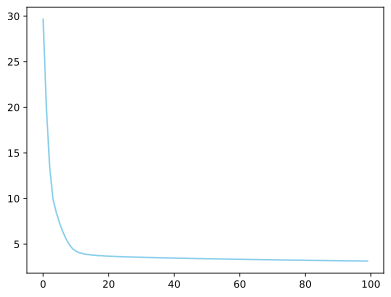

In [66]:
plt.plot(range(len(w2v_tiqqun.loss)), w2v_tiqqun.loss, color="skyblue")
plt.show()

In [67]:
def get_model_embeddings(model, tokens, word2idx, embedding_size):
    def get_embedding(model, word, word2idx):
        try:
            idx = word2idx[word]
        except KeyError:
            print("`word` not in corpus")
        one_hot = one_hot_encode(idx, len(word2idx))
        return one_hot @ model.w_target
    n_unique_tokens = len((list(set(tokens))))
    embeddings = np.zeros((n_unique_tokens, embedding_size))
    for word in list(set(tokens)):
        embeddings[word2idx[word]] = get_embedding(model, word, word2idx)
    return embeddings


In [68]:
embeddings_tiqqun = get_model_embeddings(w2v_tiqqun, tokens_tiqqun, word2idx_tiqqun, embedding_size)
embeddings_tiqqun.shape

(54, 20)

In [85]:
from sklearn.neighbors import NearestNeighbors

knn = NearestNeighbors(n_neighbors=10, metric='cosine', algorithm='auto')
knn.fit(embeddings_tiqqun)

def nearest_neighbors(knn, embeddings, word):
    neighbor_indeces = knn.kneighbors([embeddings[word2idx_tiqqun[word]]],return_distance=False)
    indeces = []
    for idx in neighbor_indeces[0]:
        indeces.append(idx2word_tiqqun[idx])
    return indeces

**PROMPT:** What are the nearest neighbors of the word 'cybernetic'. How does this change when you train the model with more data?

In [110]:
nearest_neighbors(knn, embeddings_tiqqun, 'conceptual')

['conceptual',
 'scientific',
 'call',
 'peopled',
 'governance',
 'constellation',
 'listtitle',
 'dubarle',
 'don',
 'contrast']